# *Growth Profiler* Data Analysis


# Version: 0.1.2

The *Growth Profiler* is a high throughput device for growth characterization. Growth is automatically measured via OD in plates and the results are stored in csv files. 

## 0 Libraries
Loading required libraries for analysis.

 - Input:  None
 - Output: Text: `Libraries loaded.`

In [2]:
import os
import warnings
import sys
import glob
import ipywidgets as widgets
import numpy as np
import pandas as pd
from datetime import date
#myhost = os.uname()[1]
#if myhost != 'Family':
#    print('update iambcodes')
!pip install iambcodes==0.0.20
from iambcodes.rates import *
from iambcodes.bsfun import *
#needs to import new iambcodes

# warnings.filterwarnings("ignore", category=DeprecationWarning) 
# warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# from collections import OrderedDict
import matplotlib.pyplot as plt

print('Libraries loaded.')

Libraries loaded.


In [27]:
##TEMPORARY CELL TO LOAD NEW FUNCTION
##REMOVE AFTER TESTING
##
##

import os
from datetime import date
import pandas as pd

def Create_New_ConfFile(workflow = str, target_dir = str):
    #task of the function is to generate a .txt file for the requested workflow
    #An excel file servng as a template library needs to be in the main-folder of iambjudas
    
    """
    Parameters:
    
    ##attributes = list of strings that end up as keys when loading the config file
        Comment: removed. Attributes are now stored as a library of excel sheets
    
    workflow = string of the type of worklow the conffile is generated for
    
    target_dir = string of the target directory
    
    Today = Date of use. Needs datetime-module
    
    """
    
    #generate the date
    Today = date.today().strftime('%y%m%d')
    
    
    #Check if workflow is correct
        #function Check_Workflow_Type has a list of all available Workflow types and checks if the chosen worflow
        #is part of the list
        #if true, continue
        #if false, error message about a false worklow
    if Check_Workflow_Type(workflow) == False:
        print("WARNING! The chosen worklow does not exist.")
        return False
    
    #
    #load of library.xlsx with Prewritten Files
    try:
        file = "220718_configfile_library.xlsx"
        df = pd.read_excel(file, sheet_name=workflow, keep_default_na=False)
    except FileNotFoundError:
        print("ERROR!\nThe config-file library was not found.\n\n")
        return False
    
    #write and open new file in directory indicated by Workflow
        #alternative: addition string input with the target directory
    #take list and writerow with one position per row
     
    ConfName = '{}_JUDAS_{}_{}_config.txt'.format(Today, workflow, "GENERATED")
    ConfAddress = os.path.join(target_dir, ConfName)
    print("ATTENTION!\n\n Your new config-file was generated in the folder "+ConfAddress)
    with open(ConfAddress, 'w') as f:
        for key in df.Parameters:
            print('{}'.format(key), file=f)
    #done
    
    
    return True


"""
Function to check if a workflow is legitimate or not

Sends back TRUE if workflow is known
Sends back FALSE is worklow is not recognized
"""
def Check_Workflow_Type(workflow = str):
    """
    Parameters:
    listofworklows: list of all available workflows
    """
    listofworkflows = ["BiologData",
                       "DoE",
                       'GSMM_Quality_Control',
                       "GrowthProfiler",
                       "MFA",
                       "RatesYields"
                      ]
    
    if workflow in listofworkflows:
        return True
    else:
        return False
##
##
##

## 1. Data Input

The standard growth profiler csv file contains in the first rows metadata. The first column has the header name `Time (min)` the last column contains well photos with header name `Input_Image`. Real-valued data is within parenthesis to escape the comma decimal separator (`,`). 

The analysis can be performed on a single file as well as multiple files that can be selected simultaneously. Growth results can be bundled in replicates by the input `Replicates`, make sure the replicates fit the number of wells. For growth rate analysis based on linearized exponential equation, the data is continously divided into bins with fewer samples until the maximum correlation coefficient is reached. The number of bins over the sample range is determined by the parameter `Bins`. If only linearized exponential should be used for growth rates, leave the input `Try always log-law` unchecked, if checked, a logarithmic estimation will be attempted first and this fails a linearized exponential will kick. The algorithm can fail if no clear growth is detectable. To separate growing from non-growing wells, a threshold by multiplication with the initial biomass is used (`Growth Thresh.`). Check `Export visualization` for generating a plot graph with the linearization result on the sample subset for each well. The Growth Profiler measures biomass photographically via a Green value. To convert to OD, a calibration is necessary with nonlinear estimation of the two parameters for G-value correction and e-exponent, provide these number in the corresponding input or keep the default to leave the input unchanged.

 - Input: 
     1. Click selection (also multiple): Growth rate csv file(s)
     2. `Replicates`:  integer (1-12), result bundling (1-no replicates, 2-Duplicates), applied over the complete plate
     3. `Bins`: integer (3-6), samples division during linearized exponential estimation
     4. `Try always log-law`: boolean, estimation by only linearized exponential, or both if log is possible
     5. `Export visualization`: boolean, figure with estimation of each well
     6. `Growth Thresh.`: float, multiple of the intial biomass defined as positive growth
     7. `G-exp`: float (0-10), correction exponent for G-value in calibration
     8. `e-exp`: float (-10-5), correction exponent for exponent in calibration     
 - Output: None

In [24]:
# Run this cell to load your configuration file
#
# To generate a new configuration file, leave the variable "Target_File" empty (Target_File = "")
# After filling it out, change the variable "Target_File" to the name of your config-file and run this cell again

# Target directory for configuration-file
Target_Directory = "GrowthProfiler"
# Name of your configuration file inside the target directory
Target_File = "220719_JUDAS_GrowthProfiler_GENERATED_config.txt"
#Target_File = ""


###
###
###
Target_Dir = os.path.join(os.getcwd(), 'GrowthProfiler')
ConfFile = os.path.join(Target_Dir,Target_File)
Workflow = 'GrowthProfiler'
print(ConfFile)

if Target_File:
    try:
        print('Loading analysis config file...\n\n')
        Par_Dict = read_ConfFile(ConfFile)
        if Par_Dict['Workflow']==Workflow:
            print('Configuration file fits workflow.')
        else:
            print('ERROR: Configuration file parameters not suited for the workflow.')
            ConfFile = ''
    except:
        error_message = "ERROR!\n\nSomething went wrong while loading your configurataion-file!\n"\
                        "Please make sure if everything is in order with the selected file.\n\n"\
                        "Alternatively: make sure to leave the variable 'Target_File' as an empty string!"
        print(error_message)
else:
    Create_New_ConfFile(Workflow, Target_Dir)

C:\Users\const\Desktop\SS22\iambanalyses-master\GrowthProfiler\220719_JUDAS_GrowthProfiler_GENERATED_config.txt
Loading analysis config file...


Configuration file fits workflow.


In [25]:
# General Working Directory
# For automatic reading of directory, e.g. in cloud use:
# Target_Dir = os.path.join(os.getcwd(), 'GrowthProfiler')
Target_Dir = os.path.join(os.getcwd(), 'GrowthProfiler') if not ConfFile else Par_Dict['Target_Dir']
File = 'GP-de_Example1.csv' if not ConfFile else Par_Dict['File']
FileAddress = os.path.join(Target_Dir, File)

# Output Files
# All files are attached with the current date
Today = date.today().strftime('%y%m%d')
# Choose image file type, e.g. svg, png, pdf, eps
ImageType = 'svg' if not ConfFile else Par_Dict['ImageType']

Replicates = 3 if not ConfFile else int(Par_Dict['Replicates'])
Bins = 3 if not ConfFile else int(Par_Dict['Bins'])
Law = 'log' if not ConfFile else Par_Dict['Law'] # 'log' if Log_Quest.value else 'lin'
GPsource = 'GP-de' if not ConfFile else Par_Dict['GPsource'] # 'GP-de','GP-en','Other'
GrowthThresh = 3 if not ConfFile else float(Par_Dict['GrowthThresh'])
# Background correction for GV and factors for OD conversion, G-value, e-value. For original Green Values keep the default.
GVexp = 1 if not ConfFile else float(Par_Dict['GVexp'])
eexp = 0 if not ConfFile else float(Par_Dict['eexp'])
Background = 0 if not ConfFile else float(Par_Dict['Background'])
GvalCorr = {'GVexp':GVexp, 'eexp':eexp, 'Background':Background}

Rate estimation data exportet as: GrowthProfiler\220719_GP-de_Example1_Analysis_Bins3.xlsx
Rate estimation plots exportet as: GrowthProfiler\220719_GP-de_Example1_PlotFit_Bins3.svg
         ID  Rate Rate-Std    R2 R2-Std
0  A1-A2-A3  0.19    0.016  0.99  0.005
1  A4-A5-A6   0.2    0.004  0.99  0.001
2  B1-B2-B3  0.21    0.006  0.99  0.007
3  B4-B5-B6  0.21    0.059  0.97  0.034
4  C1-C2-C3  0.21    0.004  0.98  0.014
5  C4-C5-C6  0.17    0.025  0.97  0.027


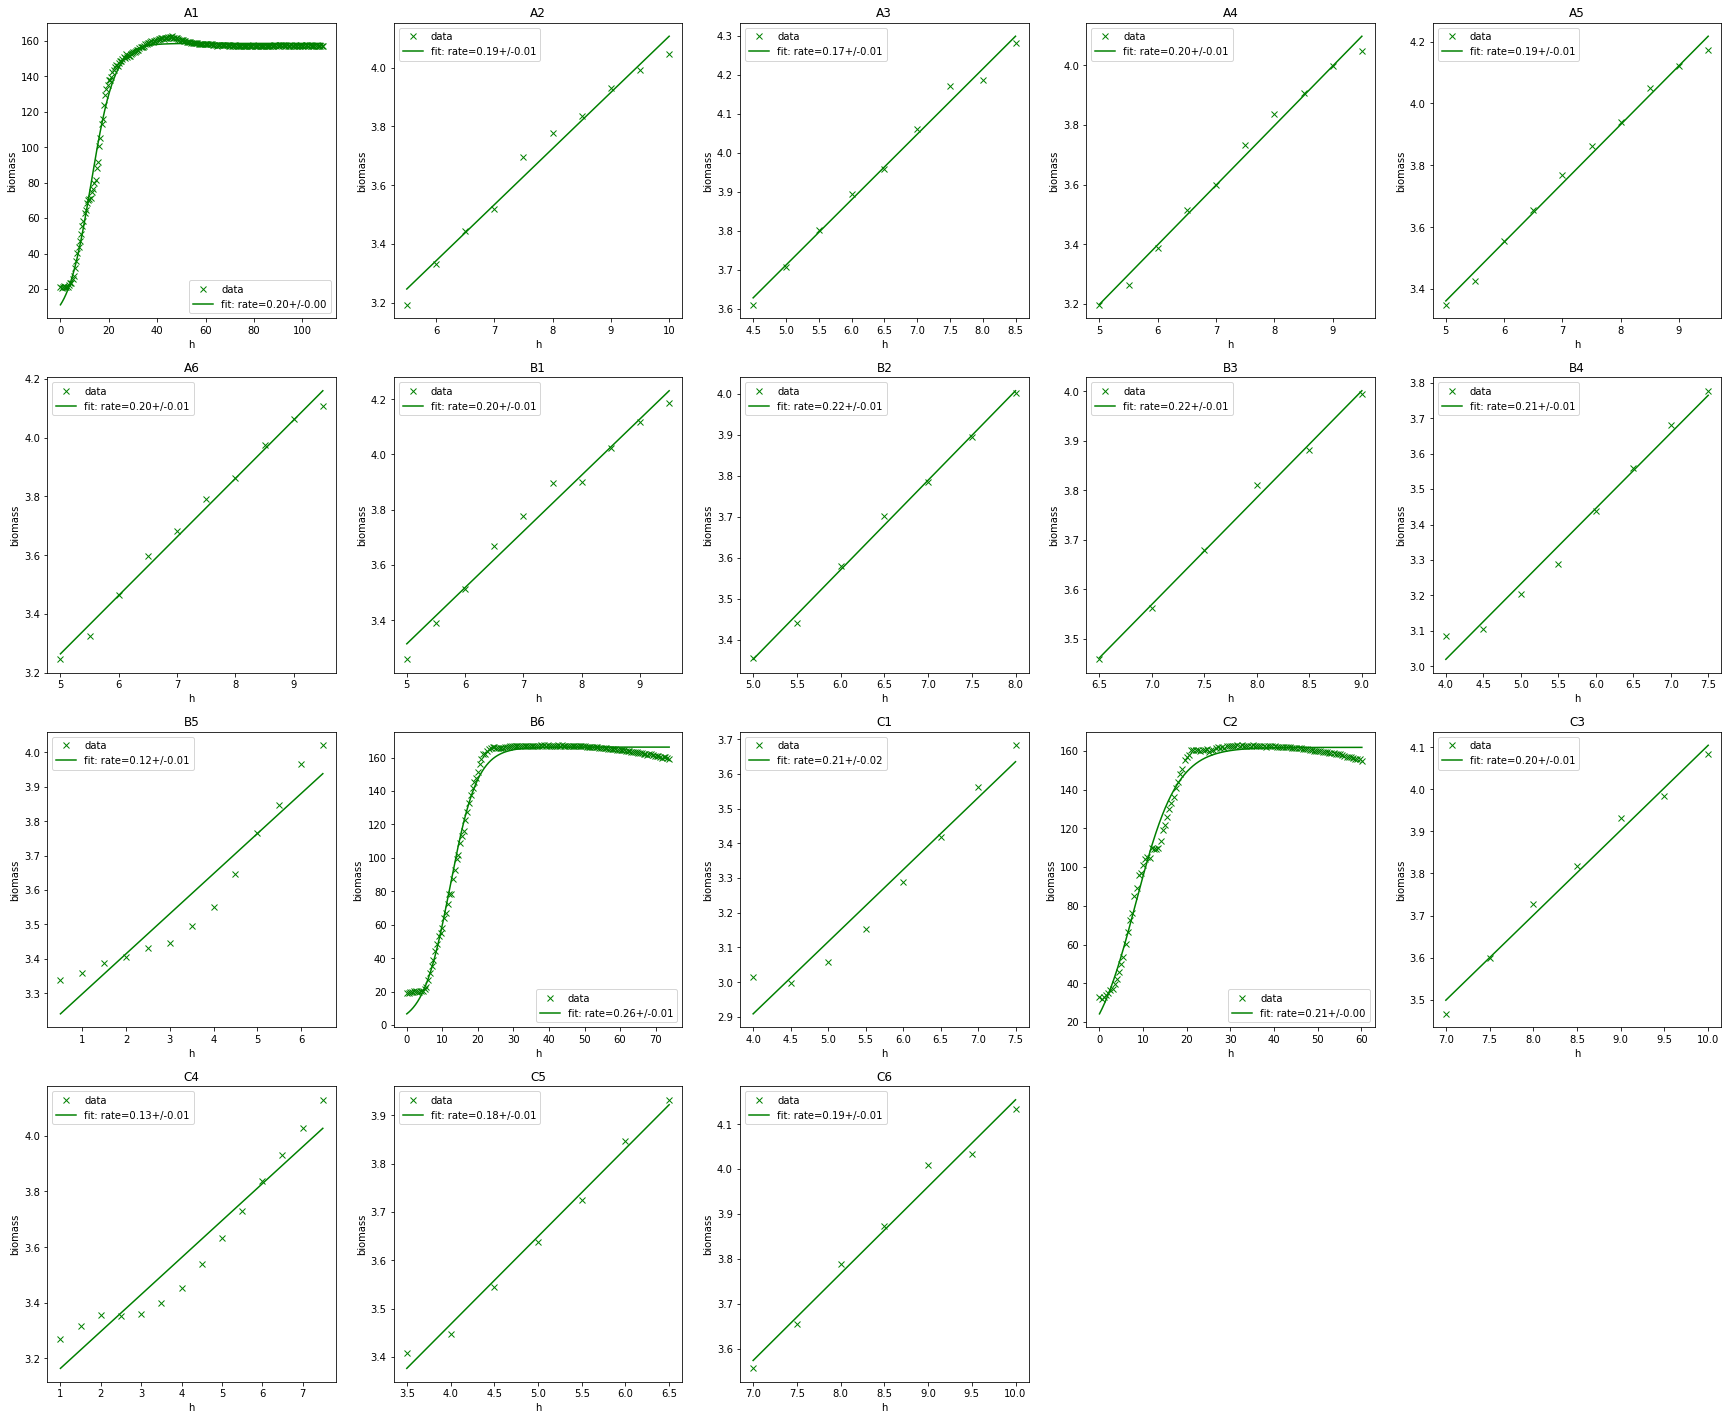

In [26]:

# if list(File_Quest.value)[0] == 'all':
#     Name = csvFiles
# else:
#     Name = [myRef for myFile in File_Quest.value for myRef in csvFiles if myRef.find(myFile)>0]

# for FileAddress in Name:
myTime, myGr = GP_PlateData(FileAddress, GrowthThresh=GrowthThresh, GVcorrect=GvalCorr, GPsource=GPsource)
rawDat_df = pd.concat([myTime, myGr], axis=1)

Wells = myGr.columns 

Visual = True
if Visual:
    FigNum = len(Wells)
    xnum = np.round(np.sqrt(FigNum))
    ynum = np.ceil(np.sqrt(FigNum))
    FigCount = 0
    plt.figure(figsize=(30,25))

WellStats = dict()
if len(Wells)%Replicates != 0:
    print('Replicate number and Wells mismatch, choose different Replicate number')
else:
    for Well in Wells:
        Biomass, myIdx = GrowthPhase(myGr[Well])
        Time = myTime[myIdx]
        result = WellFit(Time.values, Biomass,Bins, Law)
        WellStats[Well] = result 
        if result['Law'] == 'log':
            PlotPar = [result['Slope'], result['ycorrect'], result['y_lim']]
            inlog = False
        else:
            PlotPar = [result['Slope'], result['ycorrect']]
            inlog = True
        # Biomass plot
        if Visual:
            FigCount += 1
            plt.subplot(int(xnum),int(ynum),FigCount)
            PlotFit(result['time'], result['OD'], PlotPar, result['SlopeStdErr'], ['h', 'biomass'], law=result['Law'], inlog=inlog)
            plt.title(Well)
        WellStats[Well]['Samples'] = len(WellStats[Well]['time'])
        WellStats[Well].pop('OD', None)
        WellStats[Well].pop('time', None)

    mydat = pd.DataFrame(WellStats).transpose()
    # print(mydat)
    if Replicates > 1:
        RepSlope = mydat['Slope'].values.reshape(-1,Replicates)
        # the mean and intercept are weighted by the standard error of the regression
        RepStErr = mydat['SlopeStdErr'].values.reshape(-1,Replicates)
        RepCoCoe = mydat['R2'].values.reshape(-1,Replicates)
        Slope_avg_w, Slope_std_w = weighted_avg_and_std(RepSlope, weights=1/RepStErr)
        CoCoe_avg_w, CoCoe_std_w = weighted_avg_and_std(RepCoCoe, weights=1/RepStErr)
        RepIds = ['-'.join(myReps) for myReps in np.array(mydat.index).reshape(-1,Replicates)]
        results_df = pd.DataFrame(np.array([RepIds, np.round_(Slope_avg_w.astype(np.float64), decimals=2), np.round_(Slope_std_w.astype(np.float64), decimals=3), np.round_(CoCoe_avg_w.astype(np.float64), decimals=2), np.round_(CoCoe_std_w.astype(np.float64), decimals=3)]).T, columns = ['ID','Rate', 'Rate-Std', 'R2', 'R2-Std'])
    else:
        results_df = pd.DataFrame(np.array([mydat.index, np.round_(mydat['Slope'].values.astype(np.float64), decimals=2), np.round_(mydat['SlopeStdErr'].values.astype(np.float64), decimals=3), np.round_(mydat['R2'].values.astype(np.float64), decimals=2), mydat['Samples'].values]).T, columns = ['ID','Rate', 'Rate-Std', 'R2', 'Samples'])
    # saving results to xlsx
    TargetXlsx = os.path.join(Target_Dir, '{}_{}_Analysis_Bins{}.xlsx'.format(Today, os.path.splitext(os.path.split(FileAddress)[1])[0], Bins))
    print('Rate estimation data exportet as: {}'.format(TargetXlsx))
    with pd.ExcelWriter(TargetXlsx) as writer:
        rawDat_df.to_excel(writer, sheet_name='Corrected Raw Data')
        results_df.to_excel(writer, sheet_name='Analysis')
    if Visual:
        TargetPng = os.path.join(Target_Dir, '{}_{}_PlotFit_Bins{}.{}'.format(Today, os.path.splitext(os.path.split(FileAddress)[1])[0], Bins, ImageType))
        plt.savefig(TargetPng)
    print('Rate estimation plots exportet as: {}'.format(TargetPng))
    print(results_df)


### Export parameters to configuration file

In [ ]:
# Storing parameters in dictionary
# https://stackoverflow.com/questions/3972872/python-variables-as-keys-to-dict
loc=locals()
Par_Dict = {i: loc[i] for i in ('Workflow', 'Today', 'Target_Dir', 'File', 'ImageType', 'Replicates', 'Bins', 'Law', 'GPsource', 'GrowthThresh', 'GVexp', 'eexp', 'Background')}

# constructing the config.txt file
ConfName = '{}_JUDAS-Growth_{}_{}_config.txt'.format(Today, Workflow, os.path.splitext(File)[0])
ConfAddress = os.path.join(Target_Dir, ConfName)
with open(ConfAddress, 'w') as f:
    print(ConfComment, file=f)
    for key, value in Par_Dict.items():
        print('{}: {}'.format(key, value), file=f)